In [1]:
import pandas as pd
import csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import joblib
import numpy as np
from chardet import detect
import re

# File path
file_path = '/kaggle/input/wireshark1/wireshark1.csv'

# Detect file encoding
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        rawdata = f.read(50000)  # Read first 50KB to guess encoding
    return detect(rawdata)['encoding']

file_encoding = detect_encoding(file_path)
print(f"✅ Detected file encoding: {file_encoding}")

# Detect delimiter
try:
    with open(file_path, 'r', encoding=file_encoding) as f:
        first_line = f.readline()
        dialect = csv.Sniffer().sniff(first_line)
        delimiter_used = dialect.delimiter if dialect.delimiter.strip() else ','
except Exception as e:
    print(f"⚠️ Sniffer failed: {e}. Using ',' as default delimiter.")
    delimiter_used = ','

print(f"✅ Detected delimiter: '{delimiter_used}'")

# Load dataset
try:
    df = pd.read_csv(file_path, encoding=file_encoding, delimiter=delimiter_used, on_bad_lines='skip')
except UnicodeDecodeError:
    print("⚠️ Failed with detected encoding, trying latin-1 as fallback")
    df = pd.read_csv(file_path, encoding='latin-1', delimiter=delimiter_used, on_bad_lines='skip')

# Clean column names
df.columns = df.columns.str.replace(r'[^\w\s]', '', regex=True).str.strip()

# Expected columns mapping
expected_columns = {
    'Length': 'frame.len',
    'Protocol': 'ip.proto',
    'Source': 'ip.src',
    'Destination': 'ip.dst'
}

# Rename columns
for key, value in expected_columns.items():
    if key in df.columns:
        df.rename(columns={key: value}, inplace=True)

# Extract ports if 'Info' column exists
def extract_ports(info):
    match = re.search(r'(\d+)\s*>\s*(\d+)', str(info))
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

if 'Info' in df.columns:
    df['tcp.srcport'], df['tcp.dstport'] = zip(*df['Info'].map(extract_ports))
    df.drop(columns=['Info'], inplace=True)

# Convert IPs to numeric values using hashing
df['ip.src'] = df['ip.src'].apply(lambda x: hash(str(x)) % 1000)
df['ip.dst'] = df['ip.dst'].apply(lambda x: hash(str(x)) % 1000)

# Convert protocol names to numeric values
protocol_map = {'TCP': 6, 'UDP': 17, 'ICMP': 1}
df['ip.proto'] = df['ip.proto'].astype(str).str.upper().map(protocol_map).fillna(0).astype(np.int8)

# Compute occurrence frequency
df['occurrence_frequency'] = df.groupby(['ip.src', 'ip.dst'])['frame.len'].transform('count').astype(np.int32)

# Assign priority labels based on occurrence frequency thresholds
conditions = [
    (df['occurrence_frequency'] >= 10000),  # Highest occurrence
    ((df['occurrence_frequency'] >= 3500) & (df['occurrence_frequency'] < 10000)),  # Medium occurrence
    ((df['occurrence_frequency'] >= 0) & (df['occurrence_frequency'] < 3500))  # Lowest occurrence

]
choices = ['highest_occurrence', 'medium_occurrence', 'lowest_occurrence']
df['occurrence_category'] = np.select(conditions, choices, default='lowest_occurrence')

# Define features and target
features = ['frame.len', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport', 'occurrence_frequency']
X = df[features].fillna(0)
y = df['occurrence_category']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced', n_jobs=-1)
print("\nTraining model...")
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))

# Save model
joblib.dump(rf_model, 'occurrence_classification_model.pkl')
print("✅ Model saved as 'occurrence_classification_model.pkl'")

# Extract classified data
classified_data = df[['frame.len', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport', 'occurrence_frequency', 'occurrence_category']]

# Save classified data separately
classified_data.to_csv('occurrence_classified_packets.csv', index=False)
print("✅ Classified data saved as 'occurrence_classified_packets.csv'")

# Display counts of each occurrence category
print("\nPacket Occurrence Distribution:")
print(classified_data['occurrence_category'].value_counts())

# Save classified data into different CSV files
highest_occurrence_df = df[df['occurrence_category'] == 'highest_occurrence']
medium_occurrence_df = df[df['occurrence_category'] == 'medium_occurrence']
lowest_occurrence_df = df[df['occurrence_category'] == 'lowest_occurrence']

highest_occurrence_df.to_csv('highest_occurrence_packets.csv', index=False)
medium_occurrence_df.to_csv('medium_occurrence_packets.csv', index=False)
lowest_occurrence_df.to_csv('lowest_occurrence_packets.csv', index=False)

print("\n✅ Saved separate files for each occurrence category:")
print(f"- highest_occurrence_packets.csv ({len(highest_occurrence_df)} packets)")
print(f"- medium_occurrence_packets.csv ({len(medium_occurrence_df)} packets)")
print(f"- lowest_occurrence_packets.csv ({len(lowest_occurrence_df)} packets)")

✅ Detected file encoding: ascii
✅ Detected delimiter: ','
⚠️ Failed with detected encoding, trying latin-1 as fallback

Training model...
✅ Accuracy: 1.0

✅ Classification Report:
                     precision    recall  f1-score   support

highest_occurrence       1.00      1.00      1.00     14028
 lowest_occurrence       1.00      1.00      1.00     17798
 medium_occurrence       1.00      1.00      1.00     13534

          accuracy                           1.00     45360
         macro avg       1.00      1.00      1.00     45360
      weighted avg       1.00      1.00      1.00     45360

✅ Model saved as 'occurrence_classification_model.pkl'
✅ Classified data saved as 'occurrence_classified_packets.csv'

Packet Occurrence Distribution:
occurrence_category
lowest_occurrence     59326
highest_occurrence    46760
medium_occurrence     45111
Name: count, dtype: int64

✅ Saved separate files for each occurrence category:
- highest_occurrence_packets.csv (46760 packets)
- medium_occ

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from chardet import detect
import csv

# Directory path (since Kaggle mounts datasets as folders)
directory_path = '/kaggle/input/wireshark1/'

# List files in the directory
files = os.listdir(directory_path)
print("\U0001F4C2 Available files:", files)

# Identify the actual CSV file inside the directory
csv_files = [f for f in files if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError(f"\u274c No CSV file found in '{directory_path}'. Available files: {files}")

# Use the first found CSV file (assuming there's only one)
file_path = os.path.join(directory_path, csv_files[0])
print(f"✅ Using file: {file_path}")

# Detect file encoding with a larger sample size
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        rawdata = f.read(100000)  # Increase sample size for better detection
    detected = detect(rawdata)
    return detected['encoding'] if detected['encoding'] else 'utf-8'

file_encoding = detect_encoding(file_path)
print(f"✅ Detected file encoding: {file_encoding}")

# Detect delimiter
try:
    with open(file_path, 'r', encoding=file_encoding, errors='replace') as f:
        first_line = f.readline()
        dialect = csv.Sniffer().sniff(first_line)
        delimiter_used = dialect.delimiter if dialect.delimiter.strip() else ','
except Exception as e:
    print(f"⚠️ Sniffer failed: {e}. Using ',' as default delimiter.")
    delimiter_used = ','

print(f"✅ Detected delimiter: '{delimiter_used}'")

# Load dataset with fallback encodings
try:
    df = pd.read_csv(file_path, encoding=file_encoding, delimiter=delimiter_used, on_bad_lines='skip')
except UnicodeDecodeError:
    print("⚠️ UTF-8 decoding failed, trying ISO-8859-1...")
    df = pd.read_csv(file_path, encoding='ISO-8859-1', delimiter=delimiter_used, on_bad_lines='skip')
except Exception as e:
    print(f"❌ Failed to read CSV: {e}")
    raise

# Clean column names
df.columns = df.columns.str.replace(r'[^\w\s]', '', regex=True).str.strip()

# Expected columns mapping
expected_columns = {
    'Length': 'frame.len',
    'Protocol': 'ip.proto',
    'Source': 'ip.src',
    'Destination': 'ip.dst',
    'Info': 'info'
}

# Rename columns
for key, value in expected_columns.items():
    if key in df.columns:
        df.rename(columns={key: value}, inplace=True)

# Create traffic type classification based on protocol and info
def classify_traffic(row):
    protocol = str(row['ip.proto']).upper()
    info = str(row.get('info', '')).upper()
    
    # 1. Voice Communication
    if 'RTP' in info or 'RTCP' in info or 'SIP' in info or 'VOIP' in info:
        return 'Voice Communication'
    
    # 2. Video Streaming
    elif ('UDP' in protocol and ('STREAM' in info or 'VIDEO' in info)) or \
         ('TLSV1.2' in protocol and ('STREAM' in info or 'VIDEO' in info)):
        return 'Video Streaming'
    
    # 3. Web Browsing & Data Transfer
    elif 'HTTP' in info or 'HTTPS' in info or 'TLSV1.2' in protocol or \
         ('TCP' in protocol and ('GET' in info or 'POST' in info)):
        return 'Web Browsing & Data Transfer'
    
    # 4. DNS & Network Services
    elif 'LLMNR' in info or 'MDNS' in info or 'NBNS' in info or 'SSDP' in info or \
         'DNS' in info or 'DHCP' in info:
        return 'DNS & Network Services'
    
    # 5. Device Discovery & Management
    elif 'LLDP' in info or 'IEEE1905' in info or 'DB-LSP-DISC' in info or 'JSON' in info:
        return 'Device Discovery & Management'
    
    # 6. Routing & Network Layer Protocols
    elif 'ARP' in info or 'IPV4' in info or 'IPV6' in info or 'ICMPV6' in info or \
         'IGMP' in info or 'ROUTER' in info:
        return 'Routing & Network Layer Protocols'
    
    # 7. Security & Encryption
    elif 'TLS' in info or 'SSL' in info or 'AES' in info or 'ENCRYPT' in info:
        return 'Security & Encryption'
    
    # 8. Broadcast & Multicast Services
    elif 'IGMPV1' in info or 'IGMPV2' in info or 'IGMPV3' in info or 'SRVLOC' in info or \
         'BROADCAST' in info or 'MULTICAST' in info:
        return 'Broadcast & Multicast Services'
    
    else:
        return 'Other'

# Apply classification
df['traffic_type'] = df.apply(classify_traffic, axis=1)

# Convert traffic types to numerical categories
traffic_type_map = {
    'Voice Communication': 1,
    'Video Streaming': 2,
    'Web Browsing & Data Transfer': 3,
    'DNS & Network Services': 4,
    'Device Discovery & Management': 5,
    'Routing & Network Layer Protocols': 6,
    'Security & Encryption': 7,
    'Broadcast & Multicast Services': 8,
    'Other': 0
}

df['traffic_category'] = df['traffic_type'].map(traffic_type_map)

# Convert protocol names to numeric values (if not already numeric)
protocol_map = {
    'TCP': 6, 'UDP': 17, 'ICMP': 1, 'ICMPV6': 58, 'IGMP': 2,
    'TLSV1.2': 100, 'TLSV1.3': 101, 'HTTP': 80, 'HTTPS': 443,
    'ARP': -1, 'LLMNR': -2, 'MDNS': -3, 'SSDP': -4, 'DHCP': -5
}

# Handle both string and numeric protocols
if df['ip.proto'].dtype == object:
    df['ip.proto_num'] = df['ip.proto'].astype(str).str.upper().map(protocol_map).fillna(0).astype(np.int16)
else:
    df['ip.proto_num'] = df['ip.proto']

# Convert IPs to numeric values using hashing (for clustering)
# Convert IPs to numeric values using hashing (for clustering)
df['ip.src_num'] = df['ip.src'].apply(lambda x: hash(str(x)) % 1000)
df['ip.dst_num'] = df['ip.dst'].apply(lambda x: hash(str(x)) % 1000)

# Compute occurrence frequency
df['occurrence_frequency'] = df.groupby(['ip.src', 'ip.dst'])['frame.len'].transform('count').astype(np.int32)

# Compute occurrence frequency
df['occurrence_frequency'] = df.groupby(['ip.src', 'ip.dst'])['frame.len'].transform('count').astype(np.int32)

# Define features for clustering
features = [
    'frame.len', 
    'ip.proto_num', 
    'ip.src_num', 
    'ip.dst_num', 
    'occurrence_frequency',
    'traffic_category'
]

X = df[features].fillna(0)

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering with 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Map clusters to traffic types based on most common type in each cluster
cluster_mapping = {}
for cluster_id in range(8):
    cluster_data = df[df['cluster'] == cluster_id]
    if not cluster_data.empty:
        most_common = cluster_data['traffic_type'].mode()[0]
        cluster_mapping[cluster_id] = most_common

# Assign meaningful cluster names
df['cluster_name'] = df['cluster'].map(cluster_mapping)

# Save clustered data with all information
output_path = '/kaggle/working/clustered_wireshark1.csv'
df.to_csv(output_path, index=False)
print(f"✅ Clustered data saved as '{output_path}'")

# Generate summary statistics
print("\n📊 Cluster Distribution:")
print(df['cluster_name'].value_counts())

print("\n📊 Traffic Type Distribution:")
print(df['traffic_type'].value_counts())

# Save cluster statistics
stats_path = '/kaggle/working/cluster_statistics.txt'
with open(stats_path, 'w') as f:
    f.write("Cluster Distribution:\n")
    f.write(str(df['cluster_name'].value_counts()))
    f.write("\n\nTraffic Type Distribution:\n")
    f.write(str(df['traffic_type'].value_counts()))
print(f"✅ Cluster statistics saved as '{stats_path}'")

📂 Available files: ['wireshark1.csv']
✅ Using file: /kaggle/input/wireshark1/wireshark1.csv
✅ Detected file encoding: ascii
✅ Detected delimiter: ','
⚠️ UTF-8 decoding failed, trying ISO-8859-1...
✅ Clustered data saved as '/kaggle/working/clustered_wireshark1.csv'

📊 Cluster Distribution:
cluster_name
Other                             111678
Broadcast & Multicast Services     23422
DNS & Network Services             16097
Name: count, dtype: int64

📊 Traffic Type Distribution:
traffic_type
Other                                113385
Broadcast & Multicast Services        23098
DNS & Network Services                10184
Web Browsing & Data Transfer           3657
Routing & Network Layer Protocols       803
Device Discovery & Management            63
Voice Communication                       7
Name: count, dtype: int64
✅ Cluster statistics saved as '/kaggle/working/cluster_statistics.txt'


In [3]:
# Show a sample of the clustered data
print("\n📊 Clustered Data Sample:")
print(df.head(10))  # Display first 500 rows

# If running in a Jupyter Notebook, use display() for better visualization
try:
    from IPython.display import display
    display(df.head(500))
except ImportError:
    pass  # If not in a notebook, fall back to print



📊 Clustered Data Sample:
   No      Time                     ip.src     ip.dst ip.proto  frame.len  \
0   1  0.000000  fe80::699b:a2bb:d474:1689  ff02::1:3    LLMNR         86   
1   2  0.000000  fe80::699b:a2bb:d474:1689  ff02::1:3    LLMNR         86   
2   3  0.000000  fe80::699b:a2bb:d474:1689  ff02::1:3    LLMNR         86   
3   4  0.000192  fe80::699b:a2bb:d474:1689  ff02::1:3    LLMNR         86   
4   5  0.000711      HewlettPacka_9d:c2:63  Broadcast      ARP         60   
5   6  0.000711      HewlettPacka_9d:c2:63  Broadcast      ARP         60   
6   7  0.000711      HewlettPacka_9d:c2:63  Broadcast      ARP         60   
7   8  0.000750      HewlettPacka_9d:c2:63  Broadcast      ARP         60   
8   9  0.000750      HewlettPacka_9d:c2:63  Broadcast      ARP         60   
9  10  0.000750      HewlettPacka_9d:c2:63  Broadcast      ARP         60   

                                       info traffic_type  traffic_category  \
0            Standard query 0x5d72 A isatap     

,No,Time,ip.src,ip.dst,ip.proto,frame.len,info,traffic_type,traffic_category,ip.proto_num,ip.src_num,ip.dst_num,occurrence_frequency,cluster,cluster_name
0,1,0.000000,fe80::699b:a2bb:d474:1689,ff02::1:3,LLMNR,86,Standard query 0x5d72 A isatap,Other,0,-2,345,615,190,6,Other
1,2,0.000000,fe80::699b:a2bb:d474:1689,ff02::1:3,LLMNR,86,Standard query 0xdf33 A isatap,Other,0,-2,345,615,190,6,Other
2,3,0.000000,fe80::699b:a2bb:d474:1689,ff02::1:3,LLMNR,86,Standard query 0x6ffa A isatap,Other,0,-2,345,615,190,6,Other
3,4,0.000192,fe80::699b:a2bb:d474:1689,ff02::1:3,LLMNR,86,Standard query 0xceda A isatap,Other,0,-2,345,615,190,6,Other
4,5,0.000711,HewlettPacka_9d:c2:63,Broadcast,ARP,60,Who has 172.16.50.25? Tell 172.16.49.155,Other,0,-1,418,103,2407,1,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.947383,169.254.214.36,224.0.0.251,MDNS,113,Standard query response 0x0000 AAAA fe80::67a6...,Other,0,-3,669,973,12890,0,Other
496,497,0.947394,fe80::67a6:cbbe:5e86:a6ca,ff02::fb,MDNS,133,Standard query response 0x0000 AAAA fe80::67a6...,Other,0,-3,44,483,12875,3,Other
497,498,0.947533,169.254.214.36,224.0.0.252,LLMNR,69,Standard query 0xb17a ANY Mitspc-09,Other,0,-2,669,420,10225,5,Other
498,499,0.947533,fe80::67a6:cbbe:5e86:a6ca,ff02::1:3,LLMNR,89,Standard query 0xb17a ANY Mitspc-09,Other,0,-2,44,615,4735,3,Other


Loading data from: /kaggle/input/wireshark1/wireshark1.csv
Trying encoding: ascii
Failed with encoding ascii: 'ascii' codec can't decode byte 0xe2 in position 240497: ordinal not in range(128)
Trying encoding: latin1


<ipython-input-4-3f5cb1f56d0d>:44: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_series = df.groupby([pd.Grouper(freq='1S'), 'Protocol']).size().unstack(fill_value=0)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - loss: 4.8876 - mae: 1.4312 - val_loss: 6.5780 - val_mae: 1.8539
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 3.8935 - mae: 1.3199 - val_loss: 4.2097 - val_mae: 1.5024
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.9598 - mae: 1.0502 - val_loss: 2.4379 - val_mae: 1.0904
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 1.0434 - mae: 0.7849 - val_loss: 1.7359 - val_mae: 0.8450
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.7019 - mae: 0.6469 - val_loss: 1.5068 - val_mae: 0.7643
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.5532 - mae: 0.5773 - val_loss: 1.5442 - val_mae: 0.7605
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.5215 - mae: 0.5459 - val_loss: 1.7112 - val_mae: 0.7971
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.5110 - mae: 0.5371 - val_loss: 1.6846 - val_mae: 0.8067
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.4865 - mae: 0.528

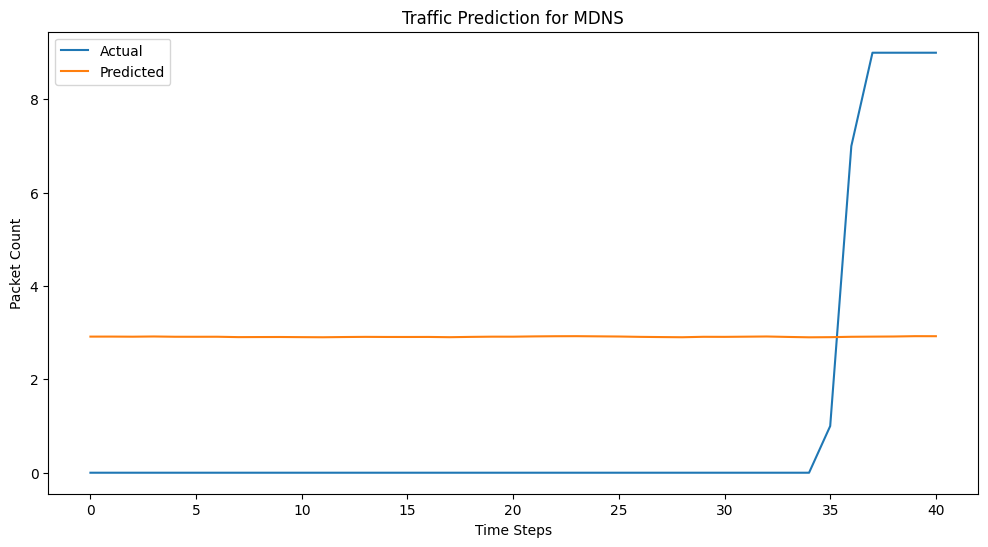

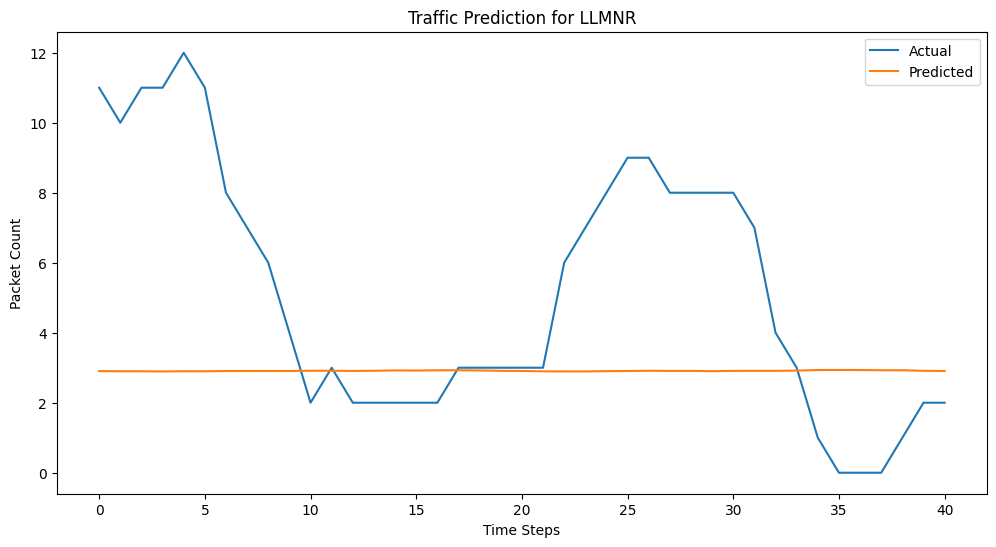

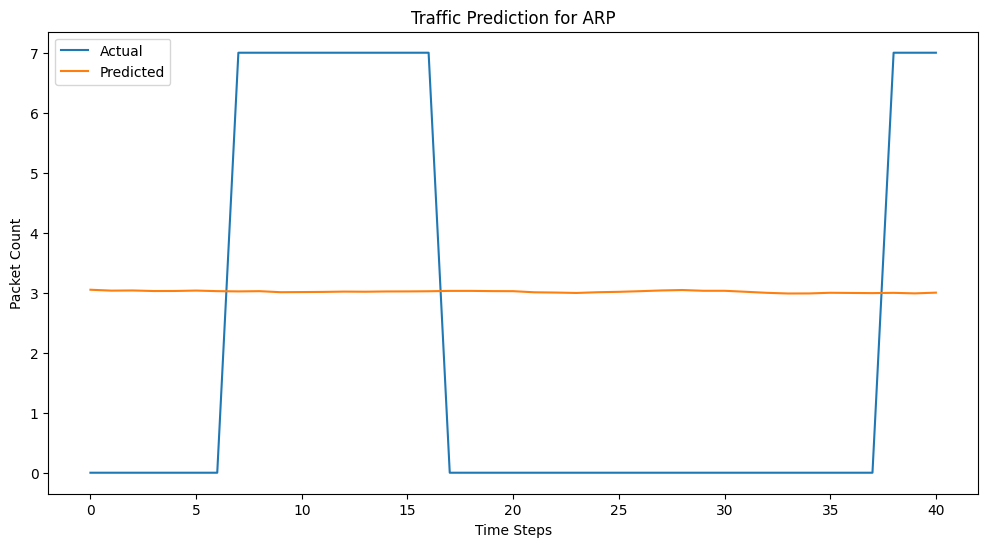

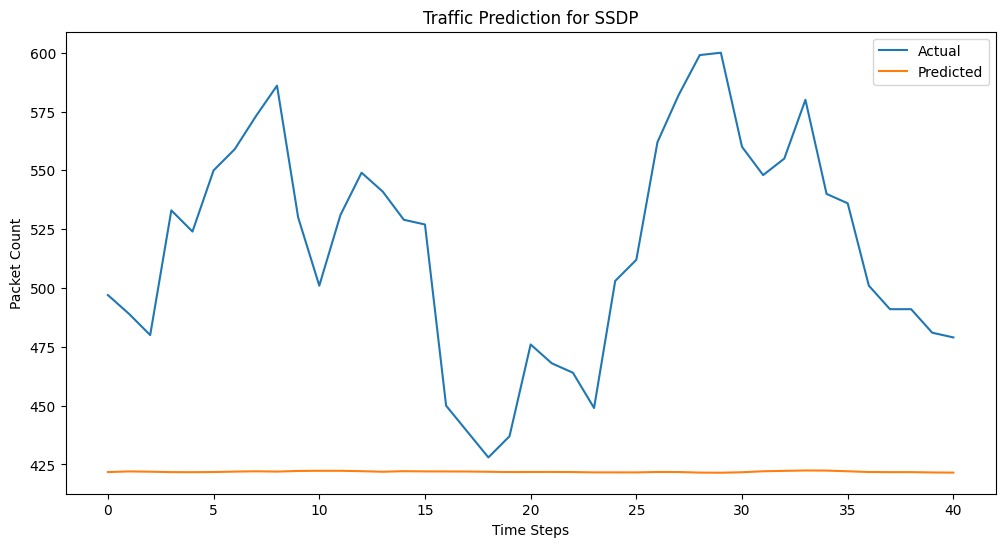

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
import chardet

def detect_encoding(filepath):
    with open(filepath, 'rb') as f:
        rawdata = f.read(100000)  # Read more bytes for better detection
        result = chardet.detect(rawdata)
    # Fallback to common encodings if confidence is low
    if result['confidence'] < 0.9:
        return 'latin1'
    return result['encoding']

def load_and_preprocess(filepath):
    try:
        # Try multiple encodings if first attempt fails
        encodings_to_try = [detect_encoding(filepath), 'latin1', 'ISO-8859-1', 'cp1252']
        
        for encoding in encodings_to_try:
            try:
                print(f"Trying encoding: {encoding}")
                df = pd.read_csv(filepath, encoding=encoding, on_bad_lines='warn')
                
                # Check if we have the minimum required columns
                if 'Time' not in df.columns or 'Protocol' not in df.columns:
                    raise ValueError("Missing required columns")
                
                # Convert Time to datetime and set as index
                try:
                    df['Time'] = pd.to_datetime(df['Time'], unit='s')
                except:
                    df['Time'] = pd.to_datetime(df['Time'])
                df.set_index('Time', inplace=True)
                
                # Create time series of protocol counts
                protocol_counts = df['Protocol'].value_counts().index.tolist()
                time_series = df.groupby([pd.Grouper(freq='1S'), 'Protocol']).size().unstack(fill_value=0)
                
                # Fill missing protocols with 0
                for protocol in protocol_counts:
                    if protocol not in time_series.columns:
                        time_series[protocol] = 0
                
                return time_series, protocol_counts
                
            except Exception as e:
                print(f"Failed with encoding {encoding}: {str(e)}")
                continue
        
        raise ValueError("All encoding attempts failed")
    
    except Exception as e:
        print(f"Error loading file: {e}")
        if os.path.exists(filepath):
            print(f"File exists at: {file_path}")
            print(f"File size: {os.path.getsize(file_path)} bytes")
        else:
            print("File path does not exist")
        return None, None

def create_sequences(data, window_size, prediction_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_horizon):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+prediction_horizon].sum(axis=0))
    return np.array(X), np.array(y)

def build_gru_model(input_shape, output_shape):
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(64, return_sequences=False),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(output_shape)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def main():
    # Parameters
    WINDOW_SIZE = 60
    PREDICTION_HORIZON = 10
    TEST_SIZE = 0.2
    EPOCHS = 50
    BATCH_SIZE = 32
    
    # File path - keeping your specified path
    file_path = '/kaggle/input/wireshark1/wireshark1.csv'
    
    # Verify file exists
    if not os.path.exists(file_path):
        print(f"File not found at: {file_path}")
        print("Please ensure:")
        print("1. The dataset is properly mounted in Kaggle")
        print("2. The filename is exactly 'wireshark1.csv'")
        print(f"Files in input directory: {os.listdir('/kaggle/input')}")
        if os.path.exists('/kaggle/input/wireshark1'):
            print(f"Files in wireshark1 directory: {os.listdir('/kaggle/input/wireshark1')}")
        return
    
    print(f"Loading data from: {file_path}")
    time_series, protocol_counts = load_and_preprocess(file_path)
    
    if time_series is None:
        print("Failed to load data. Additional troubleshooting:")
        print("1. Try opening the file in a text editor to check its contents")
        print("2. Verify the file isn't corrupted")
        print("3. Check if the file contains special characters")
        return
    
    # Normalize data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(time_series)
    
    # Create sequences
    X, y = create_sequences(scaled_data, WINDOW_SIZE, PREDICTION_HORIZON)
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, shuffle=False)
    
    # Build model
    model = build_gru_model((WINDOW_SIZE, len(protocol_counts)), len(protocol_counts))
    
    # Train model
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1)
    
    # Evaluate
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test MAE: {mae:.4f}")
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform to get actual counts
    y_test_actual = scaler.inverse_transform(y_test)
    predictions_actual = scaler.inverse_transform(predictions)
    
    # Plot results for critical protocols
    critical_protocols = ['ARP', 'LLMNR', 'MDNS', 'SSDP']
    for i, protocol in enumerate(protocol_counts):
        if protocol in critical_protocols:
            plt.figure(figsize=(12, 6))
            plt.plot(y_test_actual[:, i], label='Actual')
            plt.plot(predictions_actual[:, i], label='Predicted')
            plt.title(f'Traffic Prediction for {protocol}')
            plt.xlabel('Time Steps')
            plt.ylabel('Packet Count')
            plt.legend()
            plt.show()

if __name__ == "__main__":
    main()

Loading data from: /kaggle/input/wireshark1/wireshark1.csv
Attempting with encoding: ascii
Failed with encoding ascii: 'ascii' codec can't decode byte 0xe2 in position 240497: ordinal not in range(128)
Attempting with encoding: utf-8
Failed with encoding utf-8: 'utf-8' codec can't decode byte 0xe2 in position 33: invalid continuation byte
Attempting with encoding: latin1


<ipython-input-5-49c39230765f>:51: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_series = df.groupby([pd.Grouper(freq='1S'), 'Protocol']).size().unstack(fill_value=0)
<ipython-input-5-49c39230765f>:62: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_series = time_series.asfreq('1S', fill_value=0)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Loaded data with shape: (275, 20)
Protocols being analyzed: ['MDNS', 'ICMPv6', 'LLMNR', 'ARP', 'IGMPv1', 'DHCP', 'DHCPv6', 'SSDP', 'NBNS', 'UDP', 'LOOP', 'UDP/XML', 'IGMPv3', 'IGMPv2', 'IPv4', 'IPv6', 'BROWSER', 'ieee1905', 'TCP', 'DB-LSP-DISC/JSON']
Training model...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 13.1693 - mae: 5.5417 - val_loss: 23.1232 - val_mae: 15.8706 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 497ms/step - loss: 12.5746 - mae: 5.3695 - val_loss: 22.7042 - val_mae: 15.8575 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 497ms/step - loss: 11.9778 - mae: 5.1726 - val_loss: 22.2997 - val_mae: 15.8430 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 493ms/step - loss: 11.4497 - mae: 5.0286 - val_loss: 21.9094 - val_mae: 15.8253 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - loss: 10.9307 - mae: 4.8750 - val_loss: 21.5323 - val_mae: 15.8041 - learning_rate: 0.0010
Epoch 6/100
2/

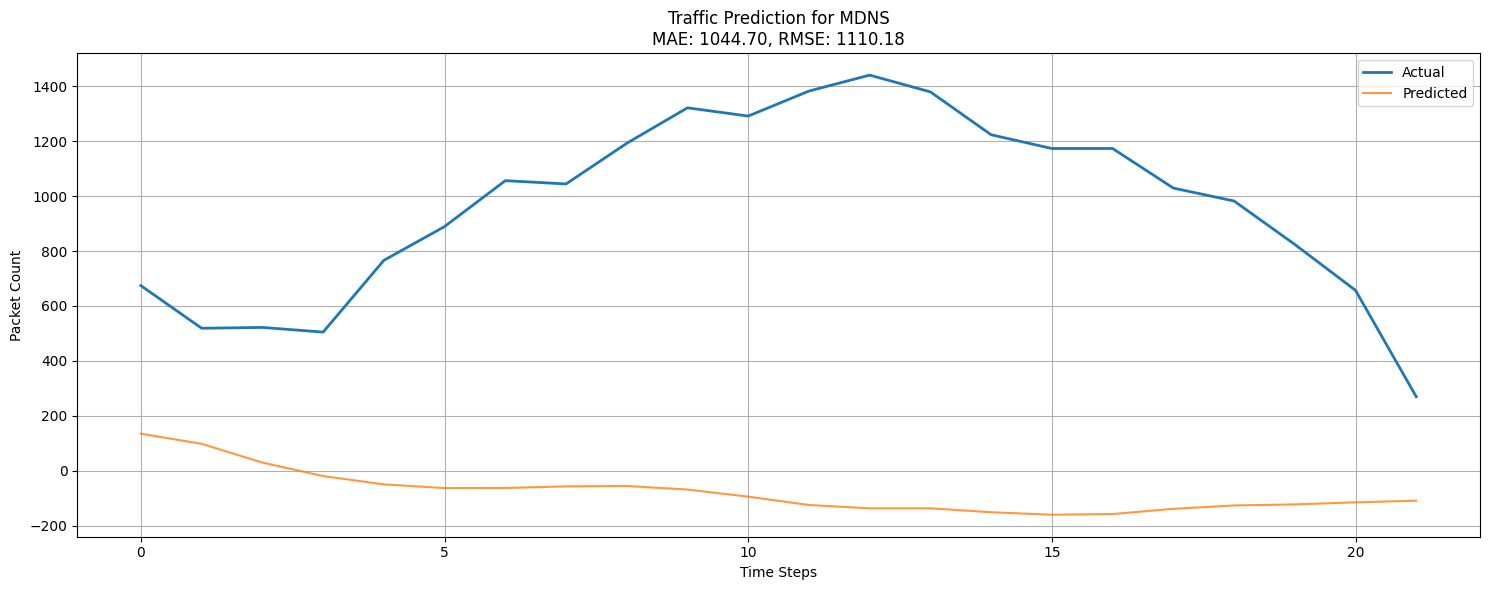

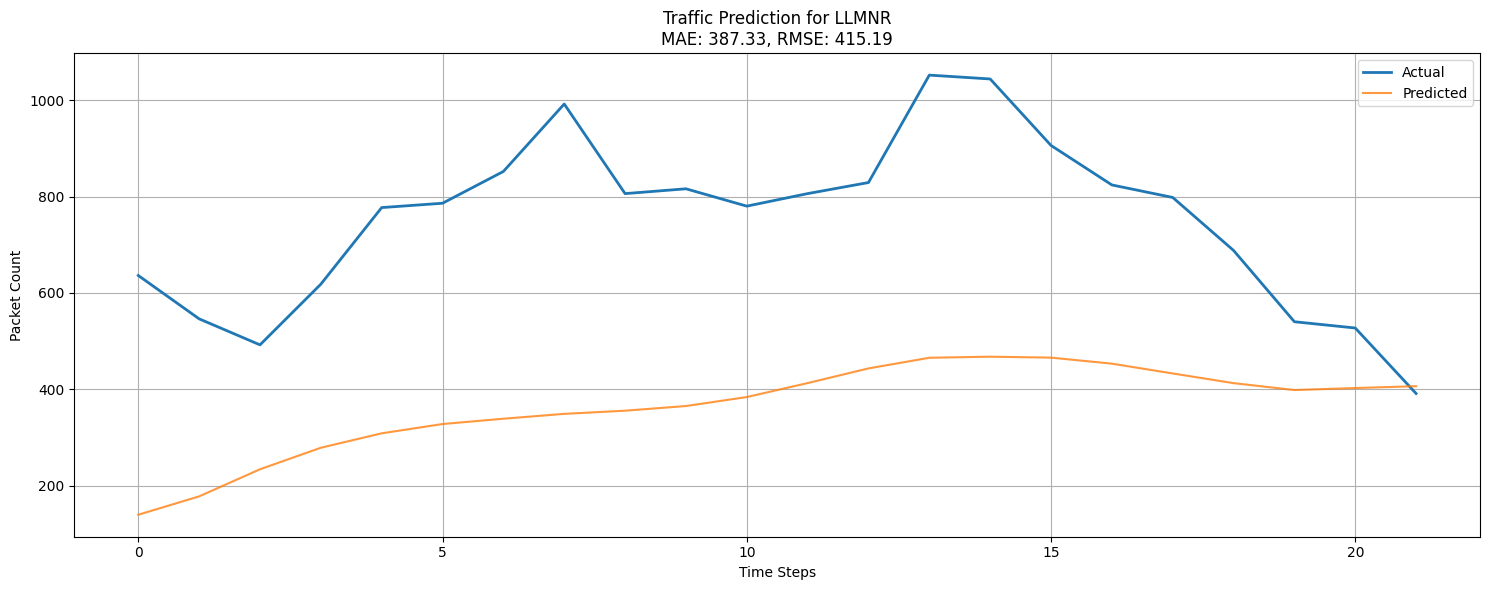

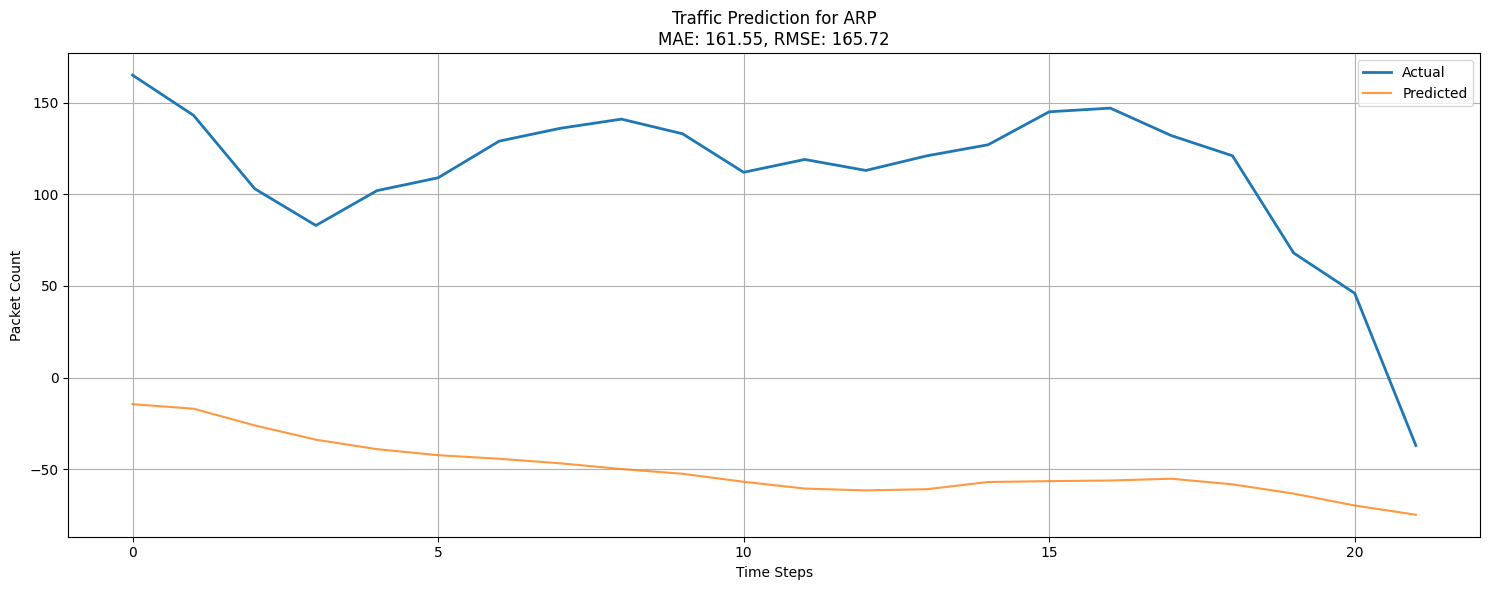

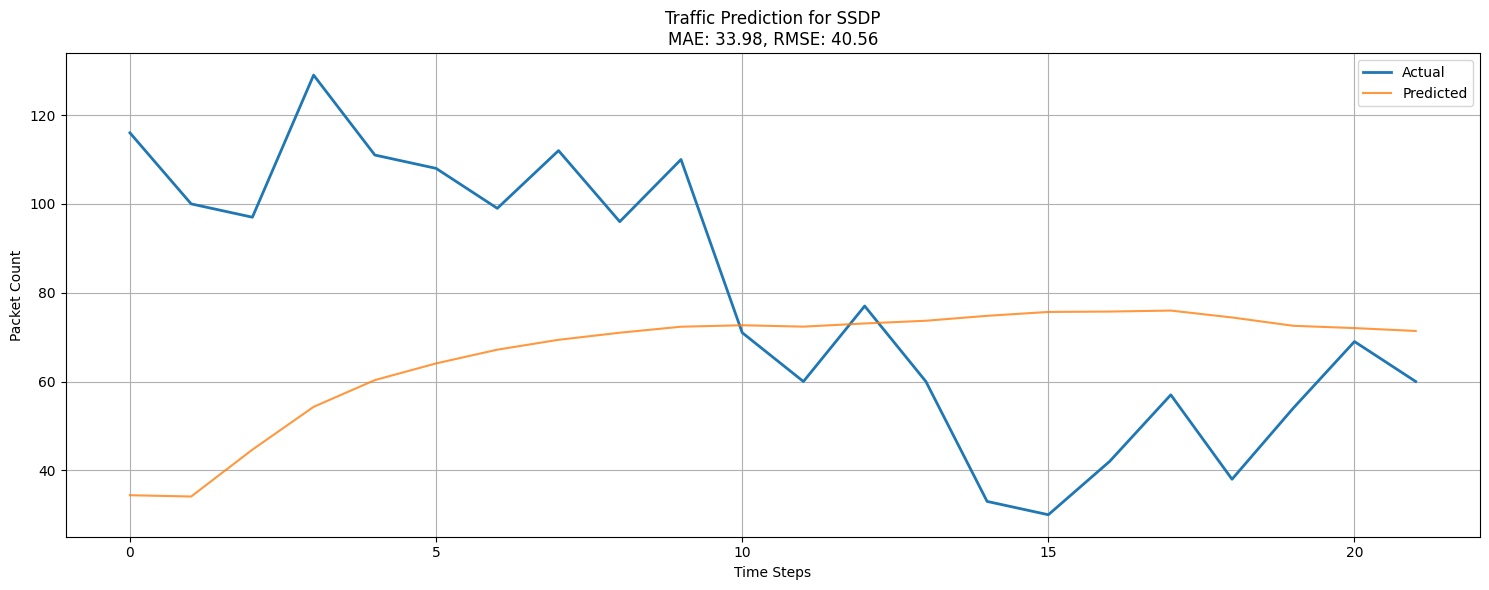

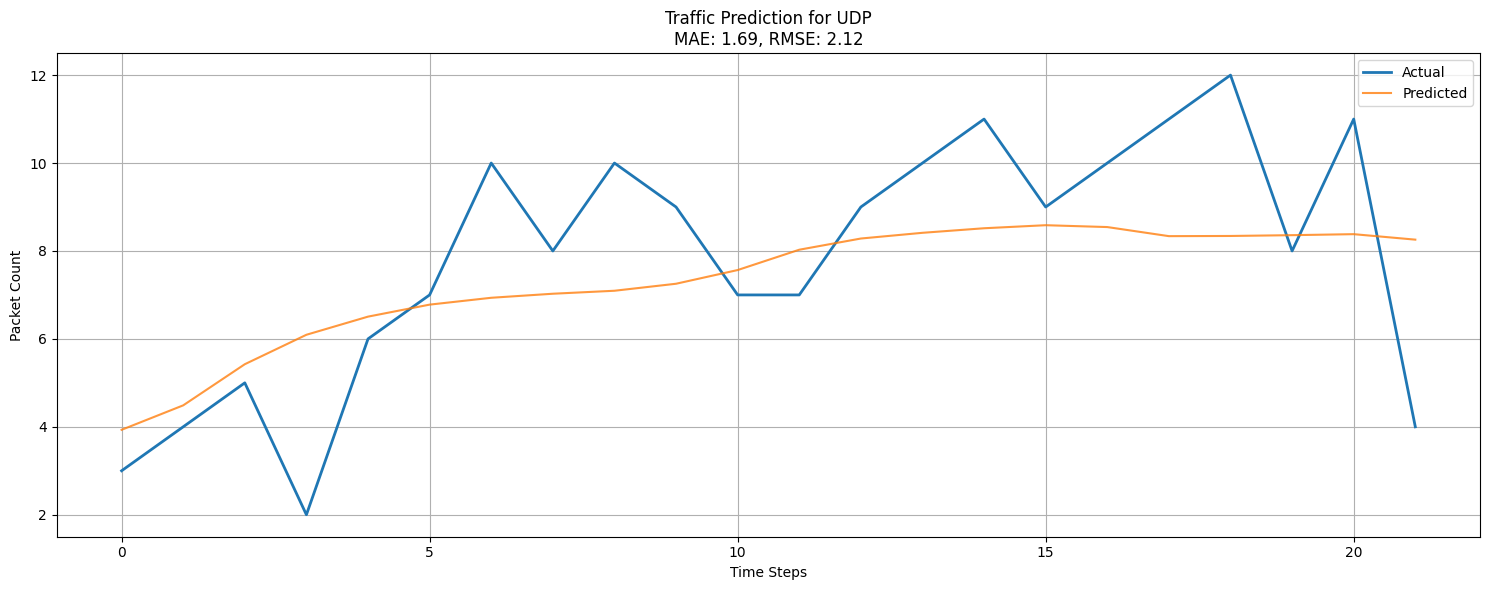

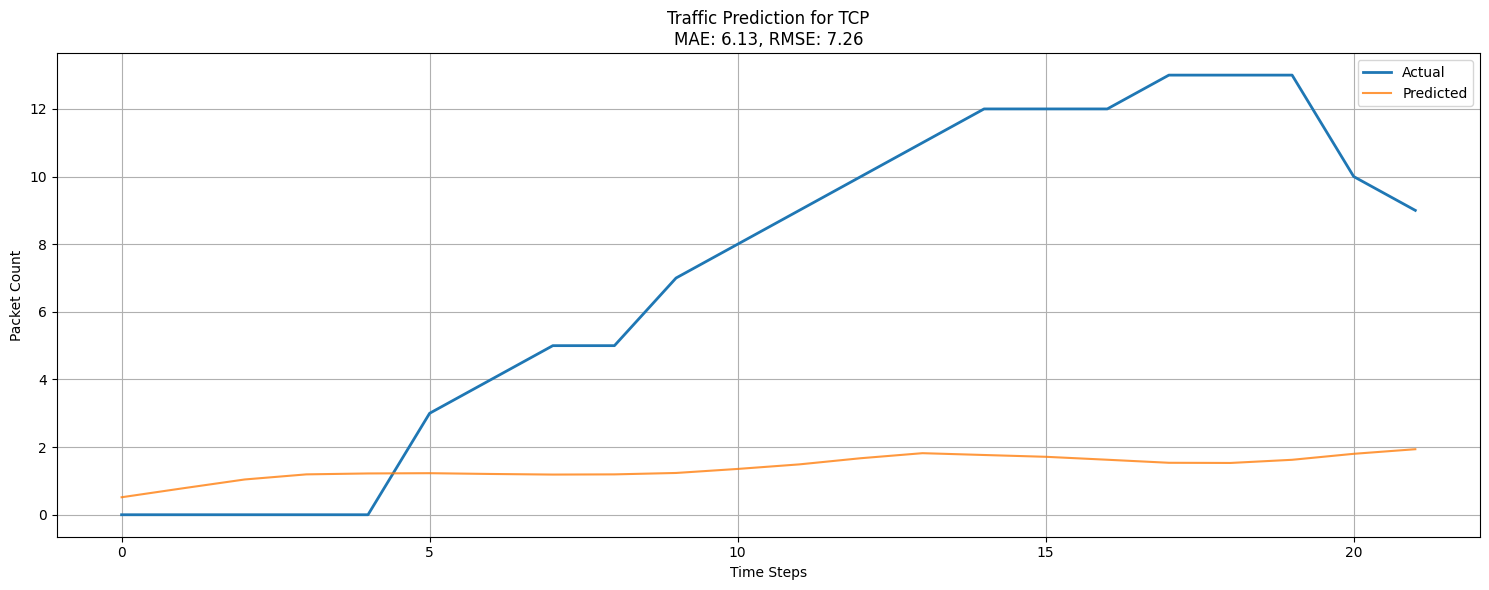

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber  # Import Huber loss
import matplotlib.pyplot as plt
import os
import chardet
from sklearn.metrics import mean_absolute_error, mean_squared_error

def detect_encoding(filepath):
    with open(filepath, 'rb') as f:
        rawdata = f.read(1000000)  # Increased buffer size for better detection
        result = chardet.detect(rawdata)
    # Fallback strategy with common encodings
    encodings_to_try = [result['encoding'] if result['confidence'] > 0.8 else None,
                        'utf-8', 'latin1', 'ISO-8859-1', 'cp1252']
    return [enc for enc in encodings_to_try if enc is not None]

def load_and_preprocess(filepath):
    encodings = detect_encoding(filepath)
    for encoding in encodings:
        try:
            print(f"Attempting with encoding: {encoding}")
            df = pd.read_csv(filepath, encoding=encoding, on_bad_lines='warn', low_memory=False)
            
            # Essential column checks
            required_cols = ['Time', 'Protocol']
            if not all(col in df.columns for col in required_cols):
                missing = [col for col in required_cols if col not in df.columns]
                raise ValueError(f"Missing required columns: {missing}")
            
            # Time conversion with robust parsing
            try:
                df['Time'] = pd.to_datetime(df['Time'], unit='s')
            except:
                df['Time'] = pd.to_datetime(df['Time'])
            df.set_index('Time', inplace=True)
            
            # Protocol processing with top-N filtering
            protocol_counts = df['Protocol'].value_counts()
            top_protocols = protocol_counts.head(20).index.tolist()  # Focus on top protocols
            df = df[df['Protocol'].isin(top_protocols)]
            
            # Create time series with 1-second resolution
            time_series = df.groupby([pd.Grouper(freq='1S'), 'Protocol']).size().unstack(fill_value=0)
            
            # Ensure all top protocols are represented
            for protocol in top_protocols:
                if protocol not in time_series.columns:
                    time_series[protocol] = 0
            
            # Sort columns for consistency
            time_series = time_series[top_protocols]
            
            # Handle missing timestamps
            time_series = time_series.asfreq('1S', fill_value=0)
            
            return time_series, top_protocols
            
        except Exception as e:
            print(f"Failed with encoding {encoding}: {str(e)}")
            continue
    
    raise ValueError(f"All encoding attempts failed for {filepath}")

def create_sequences(data, window_size, prediction_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+prediction_horizon].sum(axis=0))
    return np.array(X), np.array(y)

def build_enhanced_gru_model(input_shape, output_shape):
    model = Sequential([
        GRU(256, return_sequences=True, input_shape=input_shape, 
            kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        GRU(128, return_sequences=True, 
            kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        GRU(64, return_sequences=False),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(output_shape)
    ])
    
    optimizer = Adam(learning_rate=0.001, clipvalue=0.5)
    model.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])  # Using Huber() instead of 'huber_loss'
    return model

def evaluate_predictions(y_true, y_pred, protocols):
    metrics = {}
    for i, protocol in enumerate(protocols):
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
        metrics[protocol] = {'MAE': mae, 'RMSE': rmse}
    
    # Overall metrics
    total_mae = mean_absolute_error(y_true, y_pred)
    total_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['OVERALL'] = {'MAE': total_mae, 'RMSE': total_rmse}
    
    return metrics

def main():
    # Enhanced parameters
    WINDOW_SIZE = 120  # Increased window size for better temporal context
    PREDICTION_HORIZON = 15  # Increased prediction horizon
    TEST_SIZE = 0.15  # Reduced test size for more training data
    VAL_SIZE = 0.15  # Validation split
    EPOCHS = 100  # Increased epochs with early stopping
    BATCH_SIZE = 64  # Increased batch size
    
    # File path
    file_path = '/kaggle/input/wireshark1/wireshark1.csv'
    
    # Verify file exists
    if not os.path.exists(file_path):
        print(f"File not found at: {file_path}")
        print(f"Files in input directory: {os.listdir('/kaggle/input')}")
        if os.path.exists('/kaggle/input/wireshark1'):
            print(f"Files in wireshark1 directory: {os.listdir('/kaggle/input/wireshark1')}")
        return
    
    print(f"Loading data from: {file_path}")
    time_series, protocol_counts = load_and_preprocess(file_path)
    
    if time_series is None:
        print("Data loading failed. Exiting.")
        return
    
    print(f"Loaded data with shape: {time_series.shape}")
    print(f"Protocols being analyzed: {protocol_counts}")
    
    # Enhanced scaling - RobustScaler handles outliers better
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(time_series)
    
    # Create sequences
    X, y = create_sequences(scaled_data, WINDOW_SIZE, PREDICTION_HORIZON)
    
    # Time-based split (more realistic than random split)
    split_idx = int(len(X) * (1 - TEST_SIZE - VAL_SIZE))
    val_idx = int(len(X) * (1 - TEST_SIZE))
    
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_val, y_val = X[split_idx:val_idx], y[split_idx:val_idx]
    X_test, y_test = X[val_idx:], y[val_idx:]
    
    # Build enhanced model
    model = build_enhanced_gru_model(
        (WINDOW_SIZE, len(protocol_counts)), 
        len(protocol_counts))
    
    # Enhanced callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    
    # Train model
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1)
    
    # Evaluate
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest MAE: {test_mae:.4f}")
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform
    y_test_actual = scaler.inverse_transform(y_test)
    predictions_actual = scaler.inverse_transform(predictions)
    
    # Evaluate predictions per protocol
    metrics = evaluate_predictions(y_test_actual, predictions_actual, protocol_counts)
    print("\nProtocol-wise Metrics:")
    for protocol, values in metrics.items():
        print(f"{protocol}: MAE={values['MAE']:.2f}, RMSE={values['RMSE']:.2f}")
    
    # Enhanced plotting
    critical_protocols = ['ARP', 'LLMNR', 'MDNS', 'SSDP', 'TCP', 'UDP']
    for i, protocol in enumerate(protocol_counts):
        if protocol in critical_protocols:
            plt.figure(figsize=(15, 6))
            plt.plot(y_test_actual[:, i], label='Actual', linewidth=2)
            plt.plot(predictions_actual[:, i], label='Predicted', alpha=0.8)
            plt.title(f'Traffic Prediction for {protocol}\nMAE: {metrics[protocol]["MAE"]:.2f}, RMSE: {metrics[protocol]["RMSE"]:.2f}')
            plt.xlabel('Time Steps')
            plt.ylabel('Packet Count')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

if __name__ == "__main__":
    main()

In [6]:
import pandas as pd

def load_and_preprocess_data(filepath):
    try:
        # Try reading with utf-8 first
        df = pd.read_csv('/kaggle/input/wireshark1/wireshark1.csv', encoding="utf-8")
    except UnicodeDecodeError:
        # Fallback to ISO-8859-1 if utf-8 fails
        df = pd.read_csv('/kaggle/input/wireshark1/wireshark1.csv', encoding="ISO-8859-1")
    
    # Preprocessing steps (modify as needed)
    print("File loaded successfully!")
    print(df.head())  # Check the first few rows
    return df  # Modify as needed to extract protocol_features

# Test reading the file
filepath = "/kaggle/input/wireshark1/wireshark1.csv"
df = load_and_preprocess_data(filepath)


File loaded successfully!
   No.      Time                     Source Destination Protocol  Length  \
0    1  0.000000  fe80::699b:a2bb:d474:1689   ff02::1:3    LLMNR      86   
1    2  0.000000  fe80::699b:a2bb:d474:1689   ff02::1:3    LLMNR      86   
2    3  0.000000  fe80::699b:a2bb:d474:1689   ff02::1:3    LLMNR      86   
3    4  0.000192  fe80::699b:a2bb:d474:1689   ff02::1:3    LLMNR      86   
4    5  0.000711      HewlettPacka_9d:c2:63   Broadcast      ARP      60   

                                       Info  
0            Standard query 0x5d72 A isatap  
1            Standard query 0xdf33 A isatap  
2            Standard query 0x6ffa A isatap  
3            Standard query 0xceda A isatap  
4  Who has 172.16.50.25? Tell 172.16.49.155  


In [7]:
import pandas as pd
import numpy as np

def load_and_preprocess_data(filepath):
    try:
        # Load data with encoding handling
        df = pd.read_csv(filepath, encoding="ISO-8859-1")  # Use ISO-8859-1 if utf-8 fails
        
        # Select 1000 random rows from the middle
        start_idx = len(df) // 4  # Middle quarter start
        end_idx = start_idx + 1000
        df_sampled = df.iloc[start_idx:end_idx]  # Extract middle 1000 rows
        
        # Process protocol features (modify as needed)
        protocol_counts = df_sampled['Protocol'].value_counts().reset_index()
        protocol_counts.columns = ['protocol', 'frequency']
        protocol_counts['importance'] = np.log1p(protocol_counts['frequency'])  # Example importance calculation
        protocol_counts['priority_score'] = protocol_counts['importance'] * 10  # Example scoring
        
        protocol_features = protocol_counts.to_dict(orient='records')
        
        print("File loaded successfully!")
        print(df_sampled.head())  # Check sample
        
        return protocol_features, df_sampled

    except Exception as e:
        print(f"Error loading file: {e}")
        return [], pd.DataFrame()  # Return empty values on failure

# File path (Kaggle)
filepath = "/kaggle/input/wireshark1/wireshark1.csv"

# Load and preprocess the data
protocol_features, df = load_and_preprocess_data(filepath)


File loaded successfully!
         No.       Time                     Source       Destination Protocol  \
37799  37800  84.407818  fe80::291e:d8d3:929e:5c50          ff02::fb     MDNS   
37800  37801  84.421964               172.16.49.30   239.255.255.250     SSDP   
37801  37802  84.423277  fe80::dc95:2990:dc11:e2b2  ff02::1:ffba:cbb   ICMPv6   
37802  37803  84.428452  fe80::67a6:cbbe:5e86:a6ca          ff02::16   ICMPv6   
37803  37804  84.436204  fe80::67a6:cbbe:5e86:a6ca          ff02::16   ICMPv6   

       Length                                               Info  
37799     113  Standard query 0x0000 ANY DESKTOP-RQH3TI5._dos...  
37800     217                               M-SEARCH * HTTP/1.1   
37801      86  Neighbor Solicitation for fe80::3e33:32ff:feba...  
37802      90               Multicast Listener Report Message v2  
37803      90               Multicast Listener Report Message v2  


Trying encodings: ['ascii', 'utf-8', 'latin1', 'ISO-8859-1', 'cp1252']
Attempting with encoding: ascii
Failed with encoding ascii - trying next
Attempting with encoding: utf-8
Failed with encoding utf-8 - trying next
Attempting with encoding: latin1
File loaded successfully with encoding: latin1
           No.        Time                     Source        Destination  \
151192  151193  273.980450                    0.0.0.0    255.255.255.255   
151193  151194  273.987198                    0.0.0.0    255.255.255.255   
151194  151195  273.987326                    0.0.0.0    255.255.255.255   
151195  151196  273.992945   fe80::c53:1fa0:1b52:aabc  ff02::1:ffbb:e211   
151196  151197  274.022790  fe80::67a6:cbbe:5e86:a6ca           ff02::16   

       Protocol  Length                                               Info  
151192     DHCP     342          DHCP Discover - Transaction ID 0xd407f391  
151193     DHCP     342          DHCP Discover - Transaction ID 0xe73f8dab  
151194     DHCP

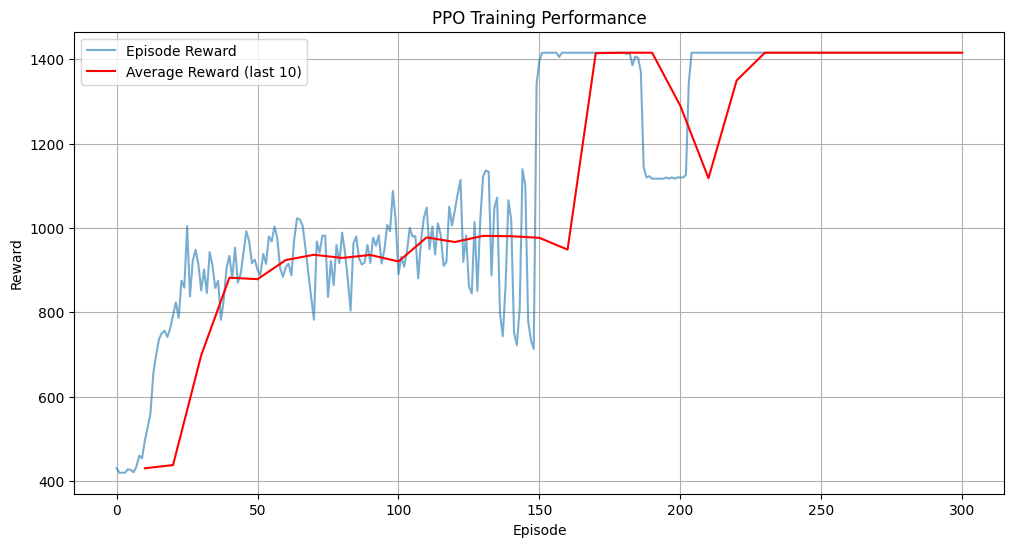


Testing trained agent...
Total test reward: 1415.76

Protocol prioritization by trained agent:
MDNS (Score=141.58): 100 selections


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import chardet

# Enhanced encoding detection with fallback
def detect_encoding(filepath):
    try:
        with open(filepath, 'rb') as f:
            rawdata = f.read(1000000)  # Read more bytes for better detection
            result = chardet.detect(rawdata)
        
        # Try detected encoding first, then common alternatives
        encodings_to_try = []
        if result['confidence'] > 0.7:
            encodings_to_try.append(result['encoding'])
        encodings_to_try.extend(['utf-8', 'latin1', 'ISO-8859-1', 'cp1252'])
        
        return encodings_to_try
    except Exception as e:
        print(f"Encoding detection error: {str(e)}")
        return ['utf-8', 'latin1']  # Default fallbacks

def load_and_preprocess_data(filepath):
    encodings = detect_encoding(filepath)
    print(f"Trying encodings: {encodings}")
    
    for encoding in encodings:
        try:
            print(f"Attempting with encoding: {encoding}")
            df = pd.read_csv(filepath, encoding=encoding, on_bad_lines='warn', low_memory=False)
            
            # Check if required columns exist
            if 'Protocol' not in df.columns:
                print("'Protocol' column not found in the data")
                continue
                
            print("File loaded successfully with encoding:", encoding)
            print(df.tail())  # Show sample data
            
            # Calculate protocol features
            protocol_counts = df['Protocol'].value_counts()
            total_packets = len(df)
            
            protocol_features = []
            for protocol, count in protocol_counts.items():
                # Calculate frequency (normalized count)
                frequency = count / total_packets
                
                # Calculate importance (log of count)
                importance = np.log(count) if count > 0 else 0
                
                # Priority score (combination of frequency and importance)
                priority_score = frequency * 100 + importance * 10
                
                protocol_features.append({
                    'protocol': protocol,
                    'frequency': frequency,
                    'importance': importance,
                    'priority_score': priority_score
                })
            
            # Sort protocols by priority score
            protocol_features.sort(key=lambda x: x['priority_score'], reverse=True)
            
            return protocol_features, df
            
        except UnicodeDecodeError:
            print(f"Failed with encoding {encoding} - trying next")
            continue
        except Exception as e:
            print(f"Error with encoding {encoding}: {str(e)}")
            continue
    
    print("All encoding attempts failed")
    return None, None

# Reinforcement Learning Environment
class PacketSchedulingEnv:
    def __init__(self, protocol_features):
        self.protocol_features = protocol_features
        self.action_dim = len(protocol_features)
        self.state_dim = len(protocol_features) * 3  # Frequency, importance, score
        
        # Initialize state
        self.reset()
    
    def reset(self):
        self.current_step = 0
        self.state = np.array([
            [pf['frequency'], pf['importance'], pf['priority_score']]
            for pf in self.protocol_features
        ]).flatten()
        return self.state
    
    def step(self, action):
        selected_protocol = self.protocol_features[action]
        reward = selected_protocol['priority_score'] / 10
        self.current_step += 1
        self.state = np.array([
            [pf['frequency'], pf['importance'], pf['priority_score']]
            for pf in self.protocol_features
        ]).flatten()
        done = self.current_step >= 100
        return self.state, reward, done, {}

# PPO Network
class PPONetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPONetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.actor = nn.Linear(64, action_dim)
        self.critic = nn.Linear(64, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.actor(x), self.critic(x)

# Fixed PPO Agent
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=1e-4, gamma=0.99, clip_param=0.2):
        self.network = PPONetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        self.gamma = gamma
        self.clip_param = clip_param
        self.memory = deque(maxlen=1000)
        
    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_probs, value = self.network(state)
        dist = Categorical(logits=action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob, value
    
    def update(self, batch):
        states = torch.FloatTensor(np.array([x[0] for x in batch]))
        actions = torch.LongTensor(np.array([x[1] for x in batch]))
        old_log_probs = torch.FloatTensor(np.array([x[2] for x in batch]))
        rewards = torch.FloatTensor(np.array([x[3] for x in batch]))
        next_states = torch.FloatTensor(np.array([x[4] for x in batch]))
        dones = torch.FloatTensor(np.array([x[5] for x in batch]))
        old_values = torch.FloatTensor(np.array([x[6] for x in batch]))
        
        # Calculate discounted returns
        returns = []
        R = 0
        for r, done in zip(reversed(rewards), reversed(dones)):
            R = r + self.gamma * R * (1 - done)
            returns.insert(0, R)
        returns = torch.FloatTensor(returns)
        
        # Normalize advantages
        advantages = returns - old_values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # PPO update
        for _ in range(4):  # Run multiple epochs of updates
            # Get new action probabilities and values
            action_probs, values = self.network(states)
            dist = Categorical(logits=action_probs)
            log_probs = dist.log_prob(actions)
            
            # Calculate entropy for exploration
            entropy = dist.entropy().mean()
            
            # Ratio of new and old policies
            ratio = torch.exp(log_probs - old_log_probs.detach())
            
            # Surrogate loss
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_param, 1 + self.clip_param) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            
            # Critic loss
            critic_loss = nn.MSELoss()(values.squeeze(), returns)
            
            # Total loss with entropy bonus
            loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy
            
            # Update network
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.network.parameters(), 0.5)
            self.optimizer.step()

def train_ppo(env, agent, num_episodes=100):
    reward_history = []
    avg_rewards = []
    
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        batch = []
        
        while not done:
            action, log_prob, value = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            batch.append((state, action, log_prob, reward, next_state, done, value))
            total_reward += reward
            state = next_state
        
        if len(batch) > 0:
            agent.update(batch)
        
        reward_history.append(total_reward)
        
        if episode % 10 == 0:
            avg_reward = np.mean(reward_history[-10:]) if len(reward_history) >= 10 else total_reward
            avg_rewards.append(avg_reward)
            print(f"Episode {episode}, Reward: {total_reward:.2f}, Avg Reward: {avg_reward:.2f}")
    
    return reward_history, avg_rewards

# Main execution
if __name__ == "__main__":
    filepath = "/kaggle/input/wireshark1/wireshark1.csv"
    
    try:
        protocol_features, df = load_and_preprocess_data(filepath)
        
        if protocol_features is None or df is None:
            print("Failed to load data. Exiting.")
            exit()
        
        # Print protocol priorities
        print("\nProtocol Priority Scores:")
        print("{:<5} {:<20} {:<10} {:<10} {:<10}".format(
            "Rank", "Protocol", "Frequency", "Importance", "Score"))
        for i, pf in enumerate(protocol_features[:20]):
            print("{:<5} {:<20} {:<10.4f} {:<10.4f} {:<10.2f}".format(
                i+1, pf['protocol'], pf['frequency'], pf['importance'], pf['priority_score']))
        
        # Limit to top protocols
        max_protocols = 20
        if len(protocol_features) > max_protocols:
            protocol_features = protocol_features[:max_protocols]
            print(f"\nLimiting to top {max_protocols} protocols for training...")
        
        # Create and train agent
        env = PacketSchedulingEnv(protocol_features)
        agent = PPOAgent(env.state_dim, env.action_dim, lr=1e-4)
        
        print("\nStarting training...")
        reward_history, avg_rewards = train_ppo(env, agent, num_episodes=300)
        
        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(reward_history, alpha=0.6, label='Episode Reward')
        plt.plot(np.arange(10, len(reward_history)+1, 10), avg_rewards, 'r-', label='Average Reward (last 10)')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.title('PPO Training Performance')
        plt.legend()
        plt.grid()
        plt.show()
        
        # Test agent
        print("\nTesting trained agent...")
        state = env.reset()
        done = False
        total_reward = 0
        action_counts = {i: 0 for i in range(env.action_dim)}
        
        while not done:
            action, _, _ = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            action_counts[action] += 1
            state = next_state
        
        print(f"Total test reward: {total_reward:.2f}")
        print("\nProtocol prioritization by trained agent:")
        sorted_actions = sorted(action_counts.items(), key=lambda x: x[1], reverse=True)
        for action, count in sorted_actions:
            if count > 0:
                pf = protocol_features[action]
                print(f"{pf['protocol']} (Score={pf['priority_score']:.2f}): {count} selections")
                
    except Exception as e:
        print(f"An error occurred: {str(e)}")